<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch4__8~9_pg__252~277.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **08 분류 실습 - 캐글 산탄데르 고객 만족 예측**

---

캐글의 산탄데르 고객 만족(Santander Customer Satisfaction) 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해보기.

산탄데르 고객 만족 예측 분석
* 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측.
* 피처 이름은 모두 익명 처리.
* 클래스 레이블 명은 TARGET, 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객

모델의 성능 평가는 ROC-AUC(ROC 곡선 영역)로 평가함

대부분이 만족이고 불만족인 데이터는 일부일 것이라 정확도 수치보다는 ROC-AUC가 더 적합함.

### **데이터 전처리**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/train_santander.csv",encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [2]:
#피처의 타입과 Null 값 알아보기
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


111개의 피처가 float형, 260개의 피처가 integer형. 모든 피처가 숫자형이며, Null값은 없음

In [3]:
#전체 데이터에서 만족과 불만족의 비율 살펴보기
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format(unsatisfied_cnt / total_cnt))
#불만족인 고객은 4%에 불과

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
#값 분포 간단히 확인
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


var3 칼럼의 경우 min 값이 -999999임.(NaN이나 특정 예외값을 변환했을 것)

print(cust_df.var3.value_counts()[:10])으로 var3의 값을 조사해보면 -999999 값이 116개가 있음을 알 수 있음

* var3은 숫자 형이고, 다른 값에 비해 -999999은 너무 편차가 심하므로 -999999를 가장 값이 많은 2로 변환.
* ID 피처는 단순 식별자에 불과하므로 피처 드롭
* 클래스 데이터 세트와 피처 데이트 세트를 분리해 별도의 데이터 세트로 저장



In [5]:
cust_df['var3'].replace(-999999, 2, inplace=True)

#피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 370)


In [6]:
#원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리
#비대칭한 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

#학습과 테스트 데이터 세트 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 약 4% 정도의 불만족값(1)

학습 세트 Shape:(60816, 370), 테스트 세트 Shape:(15204, 370)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


### **XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

먼저 XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해보기.

사이킷런 래퍼인 XGBClassifier를 기반으로 학습 수행.

n_estimator는 500으로 하되, early_stopping_rounds=100으로 설정.

성능 평가 기준이 ROC-AUC이므로 XGBClassifier가 eval_metric은 'auc'로 설정(logloss로 해도 큰 차이 없음)

여기서는 앞에서 분리한 테스트 데이터 세트를 XGBoost의 평가 데이터 세트로 이용하지만, 사실 이는 과적합의 가능성을 증가시킬 수 있음

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimators는 500으로, random state은 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

테스트 데이터 세트로 예측 시 ROC AUC는 약 0.8419

---

XGBoost의 하이퍼 파라미터 튜닝을 수행해보기

칼럼의 개수가 많으므로 과적합 가능성을 가정하고, max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차 튜닝 대상으로.

In [10]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

#cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.705626	validation_1-auc:0.715587
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.794445	validation_1-auc:0.798172
[2]	validation_0-auc:0.803745	validation_1-auc:0.804172
[3]	validation_0-auc:0.802601	validation_1-auc:0.803032
[4]	validation_0-auc:0.798543	validation_1-auc:0.797865
[5]	validation_0-auc:0.794999	validation_1-auc:0.79451
[6]	validation_0-auc:0.793067	validation_1-auc:0.792432
[7]	validation_0-auc:0.792988	validation_1-auc:0.791765
[8]	validation_0-auc:0.790465	validation_1-auc:0.790032
[9]	validation_0-auc:0.787859	validation_1-auc:0.787968
[10]	validation_0-auc:0.807212	validation_1-auc:0.807778
[11]	validation_0-auc:0.805066	validation_1-auc:0.804439
[12]	validation_0-auc:0.817418	validation_1-auc:0.815177
[13]	validation_0-auc:0.816403	validation_1-auc:0.813948
[14]	validation_0-auc:0.821508	validation_1-auc:0.818092

새로운 하이퍼 파라미터 적용 후 이전 예제보다 ROC-AUC 약간 향상됨.(0.8419->0.8448)

---

앞에서 구한 최적화 하이퍼 파라미터를 기반으로 다른 하이퍼 파라미터를 변경 또는 추가해 다시 최적화 진행

In [13]:
#n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

#성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.815296	validation_1-auc:0.812164
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.832216	validation_1-auc:0.820355
[2]	validation_0-auc:0.833595	validation_1-auc:0.824344
[3]	validation_0-auc:0.835738	validation_1-auc:0.826748
[4]	validation_0-auc:0.83708	validation_1-auc:0.825966
[5]	validation_0-auc:0.835085	validation_1-auc:0.82603
[6]	validation_0-auc:0.837534	validation_1-auc:0.828364
[7]	validation_0-auc:0.839406	validation_1-auc:0.829774
[8]	validation_0-auc:0.839507	validation_1-auc:0.828794
[9]	validation_0-auc:0.841881	validation_1-auc:0.829833
[10]	validation_0-auc:0.842242	validation_1-auc:0.830956
[11]	validation_0-auc:0.843545	validation_1-auc:0.831269
[12]	validation_0-auc:0.842393	validation_1-auc:0.830427
[13]	validation_0-auc:0.844409	validation_1-auc:0.832146
[14]	validation_0-auc:0.844632	validation_1-auc:0.832219

ROC AUC가 약 0.8456으로 이전 테스트보다 살짝 향상된 결과.

XGBoost가 GBM보다는 빠르지만 GBM 기반으로 하기 때문에 수행 시간이 상당히 많이 요구됨

->하이퍼 파라미터를 다양하게 나열해 파라미터를 튜닝하는 것이 많은 시간 소모됨

앙상블 계열 알고리즘은 과적합이나 잡음에 기본적으로 뛰어나, 파라미터 튜닝으로 성능 수치 개선이 급격하게 되지 않음

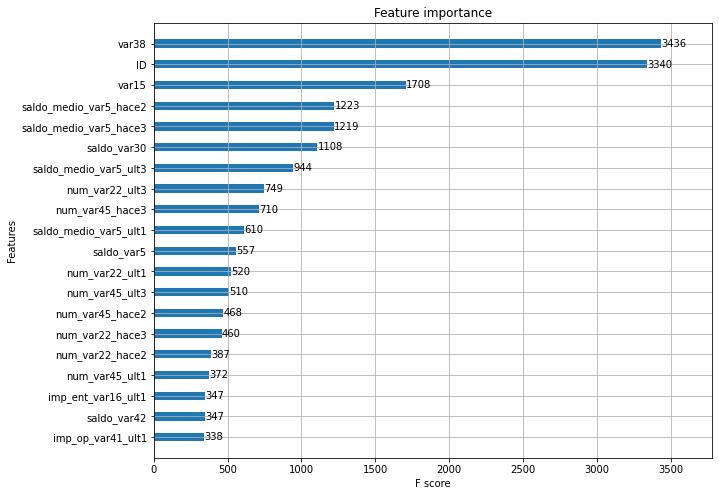

In [14]:
#튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내보기
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

var38, var15 순으로 XGBoost의 예측 성능 좌우.

### **LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

In [15]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.165052	valid_0's auc: 0.817877
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.160082	valid_0's auc: 0.817734
[3]	valid_0's binary_logloss: 0.156395	valid_0's auc: 0.826796
[4]	valid_0's binary_logloss: 0.15354	valid_0's auc: 0.831011
[5]	valid_0's binary_logloss: 0.151312	valid_0's auc: 0.833917
[6]	valid_0's binary_logloss: 0.149504	valid_0's auc: 0.833856
[7]	valid_0's binary_logloss: 0.148079	valid_0's auc: 0.83643
[8]	valid_0's binary_logloss: 0.146815	valid_0's auc: 0.837348
[9]	valid_0's binary_logloss: 0.145641	valid_0's auc: 0.839167
[10]	valid_0's binary_logloss: 0.144916	valid_0's auc: 0.838244
[11]	valid_0's binary_logloss: 0.144231	valid_0's auc: 0.838277
[12]	valid_0's binary_logloss: 0.143605	valid_0's auc: 0.838228
[13]	valid_0's binary_logloss: 0.142999	valid_0's auc: 0.838763
[14]	valid_0's binary_logloss: 0.142441	valid_0's auc: 0.838946
[15]	valid_0's binary_logloss: 0.142083	valid_0's au

ROC AUC가 약 0.8396. 학습에 걸리는 시간은 좀 더 단축됨

In [16]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32, 64],
          'max_depth':[128,160],
          'min_child_samples':[60,100],
          'subsample':[0.8,1]}

#cv는 3으로 지정
gridccv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=0, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[0]	validation_0-auc:0.705626	validation_1-auc:0.715587
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 0 rounds.
[1]	validation_0-auc:0.794445	validation_1-auc:0.798172
[2]	validation_0-auc:0.803745	validation_1-auc:0.804172
[3]	validation_0-auc:0.802601	validation_1-auc:0.803032
Stopping. Best iteration:
[2]	validation_0-auc:0.803745	validation_1-auc:0.804172

[0]	validation_0-auc:0.714816	validation_1-auc:0.71909
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 0 rounds.
[1]	validation_0-auc:0.801792	validation_1-auc:0.803273
[2]	validation_0-auc:0.80355	validation_1-auc:0.80406
[3]	validation_0-auc:0.804399	validation_1-auc:0.804302
[4]	validation_0-auc:0.800837	validation_1-auc:0.802133
Stopping. Best iteration:
[3]	validation_0-auc:0.804399	validation_1-auc:0.804302

[0]	validation_0-auc:

In [17]:
#해당 하이퍼 파라미터 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과 도출
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100,
                          max_depth=128)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.165119	valid_0's auc: 0.818835
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.159978	valid_0's auc: 0.820752
[3]	valid_0's binary_logloss: 0.156308	valid_0's auc: 0.828507
[4]	valid_0's binary_logloss: 0.153379	valid_0's auc: 0.83378
[5]	valid_0's binary_logloss: 0.151078	valid_0's auc: 0.837554
[6]	valid_0's binary_logloss: 0.149194	valid_0's auc: 0.838158
[7]	valid_0's binary_logloss: 0.147594	valid_0's auc: 0.839522
[8]	valid_0's binary_logloss: 0.146314	valid_0's auc: 0.840293
[9]	valid_0's binary_logloss: 0.145185	valid_0's auc: 0.840526
[10]	valid_0's binary_logloss: 0.144195	valid_0's auc: 0.84088
[11]	valid_0's binary_logloss: 0.143481	valid_0's auc: 0.841402
[12]	valid_0's binary_logloss: 0.142753	valid_0's auc: 0.841863
[13]	valid_0's binary_logloss: 0.142188	valid_0's auc: 0.842266
[14]	valid_0's binary_logloss: 0.141685	valid_0's auc: 0.841986
[15]	valid_0's binary_logloss: 0.141273	valid_0's au

LightGBM의 경우 테스트 데이터 세트에서 ROC-AUC가 약 0.8442로 측정됨

# **09 분류실습 - 캐글 신용카드 사기 검출**

---

* 해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있음
* Class는 0과 1로 분류되는데 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미
* 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션.
* 일반적으로 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터 세트는 이처럼 레이블 값이 극도로 불균형한 분포를 가지기 쉬움

**언더 샘플링과 오버 샘플링의 이해**

이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적어 학습시킬 때 예측 성능의 문제가 발생할 수 있음.

이상 레이블은 다양한 유형을 학습하지 못하고 정상 레이블로 치우친 학습 수행해 제대로 된 이상 데이터 검출이 어려움.

->적절한 학습 데이터를 확보하는 방안
1.   오버 샘플링(Oversampling)
2.   언더 샘플링(Undersampling)

오버 샘플링 방식이 예측 성능상 더 유리한 경우가 많아 주로 사용됨.


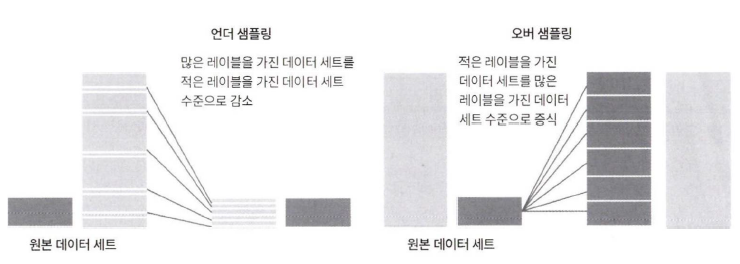

오버 샘플링의 대표적 방법: **SMOTE**(Synthetic Minority Over_sampling Technique)

: 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 k개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식.

:이를 구현한 대표적인 파이썬 패키지는 imbalanced-learn

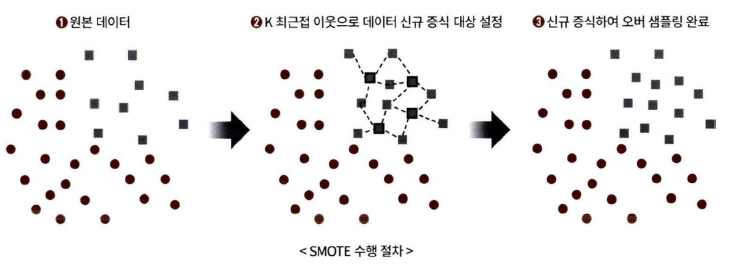

### **데이터 일차 가공 및 모델 학습/예측/평가**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


* creditcard.csv의 V로 시작하는 피처들의 의미는 알 수가 없음.
* Time 피처는 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기에 제거하기
* Amount 피처는 신용카드 트랜잭션 금액 의미
* Class는 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션

In [22]:
card_df.info()
#결측치(Missing Value) 값은 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

---

보다 다양한 사전 가공을 수행하고 이에 따른 예측 성능도 함께 비교해볼것.

이를 위해 인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 get_preprocessed_df() 함수와 데이터 가공 후 학습/테스트 데이터 세트로 반환하는 get_train_test_df() 함수 생성하기

먼저 preprocessed_df() 함수는 불필요한 Time 피처만 삭제하는 것으로부터 시작하기

In [23]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

get_train_test_dataset()는 get_preprocessed_df()를 호출한 뒤 학습 피처/레이블 데이텉 세트, 테스트 피처/레이블 데이터 세트를 반환

get_train_test_dataset()는 내부에서 train_test_split() 함수를 호출하며, 테스트 데이터 세트를 전체의 30%인 Stratified 방식으로 추출해 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만든다.

In [25]:
#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  #DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:,:-1]
  y_target = df_copy.iloc[:,-1]
  #train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  #학습과 테스트 데ㅣ터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [26]:
#서로 비슷하게 분할됐는지 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)
#큰 차이 없이 잘 분할됨

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)

  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy,precision, recall, f1, roc_auc))

In [31]:
#모델 생성. 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능 변화 살펴봄
#먼저 로지싁 회귀를 이용해 신용 카드 사기 여부 예측
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

#3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216,F1: 0.7244, AUC:0.9609


테스트 데이터 세트로 측정 시 재현율(Recall)이 0.6081, ROC-AUC가 0.9609. 

In [32]:
#이번에는 LightGBM을 이용한 모델 생성
#반복적으로 모델을 변경해 학습/예측/평가할 별도의 함수 get_model_train_eval() 생성

#인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 함

In [35]:
#LightGBM으로 모델 학습 뒤 별도의 테스트 데이터 세트에서 예측 평가 수행
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_From_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85178   117]
 [   86    62]]
정확도: 0.9976, 정밀도: 0.3464, 재현율: 0.4189,F1: 0.3792, AUC:0.7086


### **데이터 분포도 변환 후 모델 학습/예측/평가**

이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트 해보기

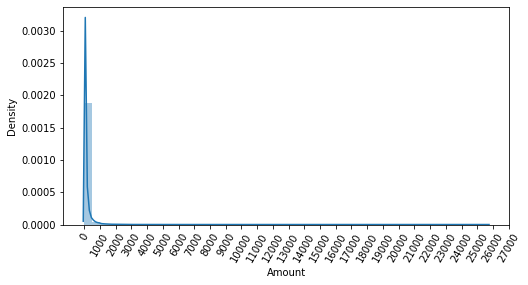

In [37]:
#creditcard.csv의 중요 피처 값의 분포도 살펴보기
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

Amount, 즉 카드 사용 금액이 1000불 이하인 데이터가 대부분이며, 27000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있음

Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능 측정해보기

In [38]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount Feature 값 변환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))

    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame 맨 앞 Column으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [39]:
#함수를 수정한 후 get_train_test_dataset()를 호출해 학습/테스트 데이터 세트를 생성한 후에
#get_model_train_eval()를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가해보기

# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,F1: 0.8421, AUC:0.9773


정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지 않음

---

이번에는 StandardScaler가 아닌 로그 변환 수행.

**로그 변환**은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나.

원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해줌

In [40]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()

    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [41]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,F1: 0.8496, AUC:0.9786


두 모델 모두 정밀도, 재현율 ,ROC-AUC에서 약간씩 성능이 개선되었음

### **이상치 데이터 제거 후 모델 학습/예측/평가**

**이상치 데이터(Outlier)**
* 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터, 아웃라이어라고도 불림
* 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우 자주 발생
* 이상치 찾아내고 제거하기-IQR(Inter Quantile Range) 방식 적용
* IQR은 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot) 방식으로 시각화 가능

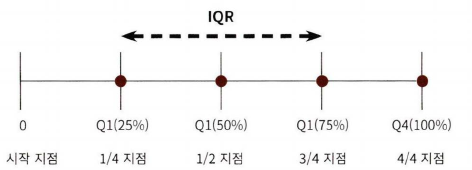

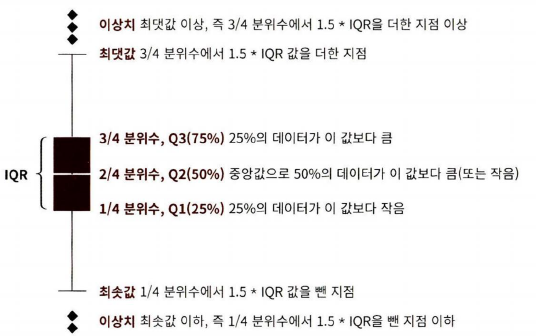

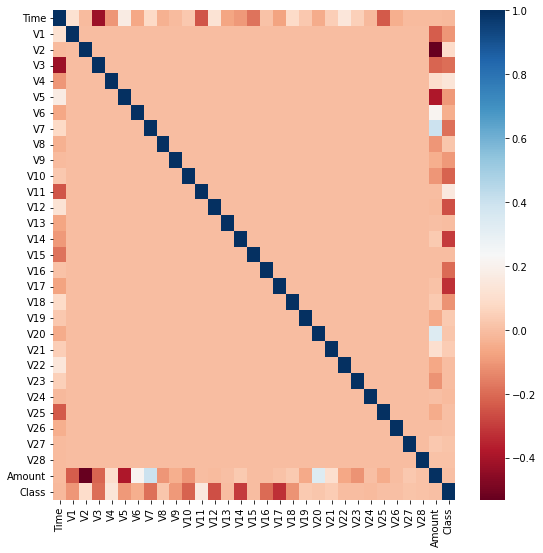

In [42]:
#DataFrame의 corr()을 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap을 통해 시각화
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

Class 피처와 음의 상관관계가 가장 높은 피처는 V14, V17->이상치 찾아 제거하기

In [43]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [44]:
#V14 칼럼에서 이상치 데이터 찾기
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


총 4개의 데이터 이상치로 추출됨.

In [46]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,F1: 0.8930, AUC:0.9831


이상치 데이터 제거 후 로지스틱 회귀와 LightGBM 모두 예측 성능 크게 향상됨.

### **SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

이번에는 SMOTE 기법으로 오버 샘플링 적용 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능 평가해보기.

* SMOTE를 적용 시 반드시 학습 데이터 세트만 오버 샘플링 해야함.

In [47]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


SMOTE 적용 후 199,362건->398,040건(거의 2배)으로 데이터 증식되고 레이블 값이 0과 1의 분포가 동일하게 199,020건으로 생성됨

In [48]:
#먼저 로지스틱 회귀 모델 학습 뒤 성능 평가
lr_clf = LogisticRegression()

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,F1: 0.1023, AUC:0.9737


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도 5.4%로 급격히 저하됨.

=로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된것.

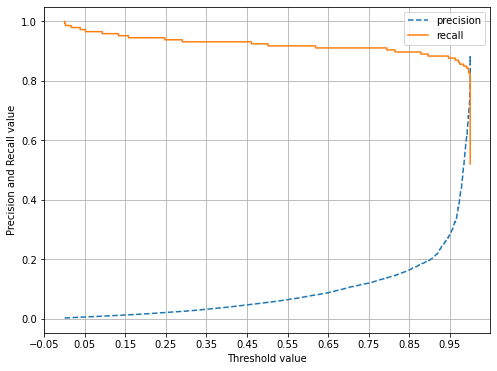

In [51]:
#분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대.

분류 결정 임곗값을 조정하더라도 임곗값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못함

---

이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가 수행

In [53]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493,F1: 0.8889, AUC:0.9789


재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 됨. 그러나 정밀도는 이전의 96.8%보다 낮은 93.23%.

SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적임.

좋은 SMOTE 패키지일수록 재현율 증가율을 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식.